In [51]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import pickle
import random

In [52]:
from google.colab import files
import io

uploaded = files.upload()

if 'corpus.txt' not in uploaded:
    raise ValueError("corpus.txt not found! Please upload it.")
if 'test.txt' not in uploaded:
    raise ValueError("test.txt not found! Please upload it.")

# Read corpus (training data)
corpus_content = uploaded['corpus.txt'].decode('utf-8')
corpus = [line.strip().upper() for line in corpus_content.split('\n') if line.strip()]

# Read test set
test_content = uploaded['test.txt'].decode('utf-8')
test_words = [line.strip().upper() for line in test_content.split('\n') if line.strip()]

print(f"\n Successfully loaded:")
print(f"   Training corpus: {len(corpus)} words")
print(f"   Test set: {len(test_words)} words")


Saving corpus.txt to corpus.txt
Saving test.txt to test.txt

 Successfully loaded:
   Training corpus: 50000 words
   Test set: 2000 words


Hidden Markov Model (HMM) for Letter Pattern Learning

This section defines and trains the HangmanHMM class a probabilistic model that learns letter occurrence and transition patterns from the training corpus (corpus.txt). It helps the reinforcement learning (RL) agent make more informed guesses during gameplay.

Why Use an HMM  
In Hangman, the probability of a letter appearing depends on:
-Its position in the word (for example, 'Q' rarely starts a word, 'E' often ends one)
-The letters that come before or after it (for example, 'U' usually follows 'Q')  
An HMM captures these sequential dependencies, modeling the structure of words to predict which letters are most likely next.

What the Code Does  
1.Training Phase (train method):  
   -Groups words by their length.  
   -Calculates letter frequencies, positional probabilities, and bigram (pairwise) probabilities.  
   -Stores these learned statistics in models indexed by word length.  

2.Prediction Phase (predict_letter_probabilities method):  
   -Given a partially revealed word and guessed letters, estimates the probability of each unguessed letter.  
   -Uses matching words, position-based probabilities, and bigram transitions to make predictions.  
   -Falls back to general letter frequencies if data is sparse.  

3.Guessing (get_best_guess):  
   -Returns the top N most likely next letters, ranked by predicted probability.  

Purpose  
The HMM acts as a linguistic guide for the RL agent, providing knowledge about English spelling patterns.  
It improves learning efficiency by biasing exploration toward statistically likely letters instead of random ones.


In [55]:
class HangmanHMM:
    """HMM for learning letter patterns in words"""

    def __init__(self):
        self.models = {}
        self.letter_frequencies = {}

    def train(self, corpus):
        """Train HMM on corpus - THIS ONLY USES TRAINING DATA"""
        print("\n🔄 Training HMM on corpus.txt...")

        # Group by length
        words_by_length = defaultdict(list)
        for word in corpus:
            words_by_length[len(word)].append(word.upper())

        # Overall letter frequencies
        all_letters = ''.join(corpus).upper()
        letter_counts = Counter(all_letters)
        total = sum(letter_counts.values())
        self.letter_frequencies = {l: c/total for l, c in letter_counts.items()}

        # Train per length
        for length, words in words_by_length.items():
            # Position probabilities
            position_probs = [defaultdict(int) for _ in range(length)]
            for word in words:
                for pos, letter in enumerate(word):
                    position_probs[pos][letter] += 1

            # Normalize
            for pos in range(length):
                total = sum(position_probs[pos].values())
                for letter in position_probs[pos]:
                    position_probs[pos][letter] /= total

            # Bigrams
            bigram_counts = defaultdict(lambda: defaultdict(int))
            for word in words:
                for i in range(len(word)-1):
                    bigram_counts[word[i]][word[i+1]] += 1

            bigram_probs = {}
            for l1 in bigram_counts:
                total = sum(bigram_counts[l1].values())
                bigram_probs[l1] = {l2: c/total for l2, c in bigram_counts[l1].items()}

            self.models[length] = {
                'position_probs': position_probs,
                'bigram_probs': bigram_probs,
                'words': words
            }

        print(f"✓ Trained models for {len(self.models)} word lengths")

    def _get_matching_words(self, pattern, words):
        """Find words matching pattern"""
        matches = []
        for word in words:
            if len(word) != len(pattern):
                continue
            if all(p == '_' or p == w for p, w in zip(pattern, word)):
                matches.append(word)
        return matches

    def predict_letter_probabilities(self, masked_word, guessed_letters):
        """Predict letter probabilities for current state"""
        length = len(masked_word)

        if length not in self.models:
            probs = self.letter_frequencies.copy()
        else:
            model = self.models[length]
            probs = defaultdict(float)

            # Find matching words
            # This logic is simple: find words that fit the pattern
            # and count unguessed letters from that pool.
            matches = self._get_matching_words(masked_word, model['words'])

            # Limit matches to avoid slowness and overfitting on huge lists
            if matches and len(matches) < 2000:
                for word in matches:
                    for letter in set(word):
                        if letter not in guessed_letters:
                            probs[letter] += 1
                total = sum(probs.values())
                if total > 0:
                    probs = {l: p/total for l, p in probs.items()}

            # --- NEW, SMARTER FALLBACK ---
            # If no matches (or too many matches), use a smarter hybrid model
            if not probs:
                positional_scores = defaultdict(float)
                bigram_scores = defaultdict(float)
                all_unguessed = set('ABCDEFGHIJKLMNOPQRSTUVWXYZ') - guessed_letters

                for pos, char in enumerate(masked_word):
                    if char == '_':
                        # 1. Positional Prob
                        for letter, prob in model['position_probs'][pos].items():
                            if letter not in guessed_letters:
                                positional_scores[letter] += prob

                        # 2. Bigram Prob (from left)
                        if pos > 0 and masked_word[pos-1] != '_':
                            left_char = masked_word[pos-1]
                            if left_char in model['bigram_probs']:
                                for letter, prob in model['bigram_probs'][left_char].items():
                                    if letter not in guessed_letters:
                                        # Weight bigrams higher
                                        bigram_scores[letter] += prob * 1.5

                        # 3. Bigram Prob (to right)
                        if pos < length - 1 and masked_word[pos+1] != '_':
                            right_char = masked_word[pos+1]
                            for letter in all_unguessed:
                                if letter in model['bigram_probs'] and right_char in model['bigram_probs'][letter]:
                                    # Weight bigrams higher
                                    bigram_scores[letter] += model['bigram_probs'][letter][right_char] * 1.5

                # Combine scores
                for letter in all_unguessed:
                    # Use a product (sum of logs) for better probabilistic combination
                    # We add 1 to positional to avoid zeroing out
                    score = (positional_scores.get(letter, 0) + 0.1) * (bigram_scores.get(letter, 0) + 1.0)
                    if score > 0:
                        probs[letter] = score
            # --- END OF NEW FALLBACK ---

        # Remove guessed
        for letter in guessed_letters:
            probs.pop(letter, None)

        # Normalize
        total = sum(probs.values())
        if total > 0:
            probs = {l: p/total for l, p in probs.items()}

        # Final fallback to general frequency if all else fails
        if not probs:
            for letter, freq in self.letter_frequencies.items():
                if letter not in guessed_letters:
                    probs[letter] = freq

        return probs

    def get_best_guess(self, masked_word, guessed_letters, top_n=5):
        """Get top N letter guesses"""
        probs = self.predict_letter_probabilities(masked_word, guessed_letters)
        return sorted(probs.items(), key=lambda x: x[1], reverse=True)[:top_n]

# Train HMM on training corpus ONLY
hmm = HangmanHMM()
hmm.train(corpus)  # Uses only corpus.txt

# Test HMM
print("\n🧪 Testing HMM predictions:")
test_cases = [("___", set()), ("A____", {'E', 'T'}), ("__E", {'A', 'I'})]
for pattern, guessed in test_cases:
    preds = hmm.get_best_guess(pattern, guessed, top_n=3)
    print(f"  {pattern} (guessed: {guessed}) → {[(l, f'{p:.3f}') for l, p in preds]}")


🔄 Training HMM on corpus.txt...
✓ Trained models for 24 word lengths

🧪 Testing HMM predictions:
  ___ (guessed: set()) → [('A', '0.125'), ('O', '0.115'), ('I', '0.062')]
  A____ (guessed: {'E', 'T'}) → [('A', '0.248'), ('I', '0.090'), ('O', '0.079')]
  __E (guessed: {'I', 'A'}) → [('E', '0.393'), ('Y', '0.107'), ('O', '0.071')]


Reinforcement Learning is a type of machine learning where an agent learns by interacting with an environment.
It takes actions, receives rewards or penalties, and gradually learns to make better decisions to maximize total reward over time.

We use RL because:

The Hangman game involves sequential decision making, each letter guess affects future outcomes.

There is no fixed dataset of right answers; the agent must learn through experience.

RL helps the agent balance exploration and exploitation — trying new letters vs. using what it already knows.

Over many games, the agent learns an optimal guessing strategy to win more often with fewer mistakes.

In short: we use RL so the Hangman agent can learn to play the game on its own through rewards and punishments, just like us humans learning by practice.

In [ ]:
# RL defines the state (masked word), action (guessed letter), reward (feedback), and next state 
# the four components of a reinforcement learning loop.
#State space: All possible masked word patterns and guessed letter combinations.
#Action space: The 26 English alphabet letters (A–Z).


class HangmanEnvironment:  #defines a simulation environment for the game where the RL learns
    """Hangman game environment""" 

    def __init__(self, word_list, max_wrong=6):
        self.word_list = word_list # A list of possible words
        self.max_wrong = max_wrong #A maximum number of wrong guesses
        self.reset() #start a new game

    def reset(self, word=None): # resets the environment for a new game
        """Start new game"""
        self.target = (word or random.choice(self.word_list)).upper()
        self.word_length = len(self.target)
        self.guessed_letters = set()
        self.correct_guesses = set()
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.game_over = False
        self.won = False
        self.masked_word = ['_'] * self.word_length
        return self._get_state() # returns the initial state of the environment

    def _get_state(self): # Returns a dictionary representation of the current game status
        """Current state"""
        return {
            'masked_word': ''.join(self.masked_word),
            'guessed_letters': self.guessed_letters.copy(),
            'lives_remaining': self.max_wrong - self.wrong_guesses,
            'word_length': self.word_length,
            'game_over': self.game_over,
            'won': self.won
        }

    def step(self, letter):
        """Guess letter"""
        letter = letter.upper()
        #If the game has already ended, any further action returns immediately with no reward
        if self.game_over:
            return self._get_state(), 0, True, {'error': 'Game over'} 

        # If the player repeats a letter: Adds a penalty of –20 reward points, Marks repeated=True in info
        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            return self._get_state(), -20, False, {'repeated': True}

        self.guessed_letters.add(letter)

        # Reveals the letter at all its positions in the word.
        if letter in self.target:
            self.correct_guesses.add(letter)
            for i, c in enumerate(self.target):
                if c == letter:
                    self.masked_word[i] = letter

            if '_' not in self.masked_word:
                self.game_over = True
                self.won = True
                return self._get_state(), 100, True, {'correct': True, 'win': True} #Big positive reward for winning
            else:
                return self._get_state(), 5, False, {'correct': True} # Small positive reward.
        else:
            # Incorrect guess: Increases wrong guess count by 1, If max wrong guesses reached, ends game with –100 reward points; otherwise, –10 reward points.
            self.wrong_guesses += 1
            if self.wrong_guesses >= self.max_wrong:
                self.game_over = True
                return self._get_state(), -100, True, {'correct': False, 'loss': True}
            else:
                return self._get_state(), -10, False, {'correct': False}
    # Returns a list of letters still available to guess.
    #The RL agent uses this to decide which actions are valid.
    def get_valid_actions(self):
        """Unguessed letters"""
        return list(set('ABCDEFGHIJKLMNOPQRSTUVWXYZ') - self.guessed_letters)
    # After each game, this reports the outcome
    def get_stats(self):
        """Game stats"""
        return {
            'won': self.won,
            'wrong_guesses': self.wrong_guesses,
            'repeated_guesses': self.repeated_guesses,
            'target_word': self.target
        }

print("✓ Hangman environment created")

✓ Hangman environment created


 Reinforcement Learning Agent with HMM Guidance

This class implements a Q-Learning based Reinforcement Learning (RL) agent that learns to play the Hangman game.  
It is enhanced with a Hidden Markov Model (HMM), which helps the agent make smarter guesses by estimating letter probabilities based on observed word patterns.

 Models Used:
 Q-Learning (RL): 
 A value-based learning method that updates Q-values (state-action values) using rewards to learn the best policy.
  
-Hidden Markov Model (HMM):  
  Provides probabilistic guidance by predicting which letters are most likely to appear next in the word, improving exploration quality.

 What this code does:
-Uses Q-Learning to update action values (Q-table) based on rewards from the Hangman environment.  
-Uses an epsilon greedy policy:  
-With probability e, it explores (chooses random/HMM based guesses).  
-With probability 1−e, it exploits (chooses the best known guess).  
-Trains over multiple episodes to minimize wrong guesses and maximize win rate.  
-Evaluates performance by computing success rate and scores across test games.


In [ ]:
class HangmanRLAgent:
    """Q-Learning agent with HMM guidance"""

    def __init__(self, hmm, alpha=0.1, gamma=0.95, epsilon=1.0,
                 epsilon_decay=0.9995, epsilon_min=0.05):
        # Initialize parameters
        self.hmm = hmm                       # Hidden Markov Model for probabilistic letter guidance
        self.alpha = alpha                   # Learning rate for Q-value updates
        self.gamma = gamma                   # Discount factor (importance of future rewards)
        self.epsilon = epsilon               # Initial exploration probability
        self.epsilon_decay = epsilon_decay   # Factor to gradually reduce exploration
        self.epsilon_min = epsilon_min       # Minimum exploration threshold
        self.q_table = defaultdict(lambda: defaultdict(float))  # Q-values: {state_hash: {action: value}}
        self.episode_rewards = []            # Tracks total reward per episode
        self.episode_lengths = []            # Tracks number of steps per episode
        self.wins = []                       # Tracks win outcomes per episode

    def _state_hash(self, state):
        """Convert game state into a unique hashable string"""
        return f"{state['masked_word']}|{''.join(sorted(state['guessed_letters']))}|{state['lives_remaining']}"

    def get_action(self, state, valid_actions, training=True):
        """Selects an action using an epsilon-greedy policy"""
        if not valid_actions:
            return None

        # Exploration phase 
        if training and random.random() < self.epsilon:
            # Use HMM to get letter probabilities and sample accordingly
            probs = self.hmm.predict_letter_probabilities(
                state['masked_word'], state['guessed_letters'])
            if probs:
                letters = [l for l in probs.keys() if l in valid_actions]
                if letters:
                    weights = [probs[l] for l in letters]
                    # Choose letter based on predicted probability distribution
                    return np.random.choice(letters, p=np.array(weights)/sum(weights))
            # Fallback: random valid action
            return random.choice(valid_actions)

        # Exploitation phase 
        state_hash = self._state_hash(state)
        q_vals = {}
        hmm_probs = self.hmm.predict_letter_probabilities(
            state['masked_word'], state['guessed_letters'])

        # Combine Q-values and HMM guidance to score each valid action
        for action in valid_actions:
            q_vals[action] = self.q_table[state_hash].get(
                action, hmm_probs.get(action, 0.01) * 10)

        # Choose the action with the highest Q-value
        return max(q_vals.items(), key=lambda x: x[1])[0]

    def update_q(self, state, action, reward, next_state, done):
        """Performs the Q-learning update step"""
        s_hash = self._state_hash(state)
        ns_hash = self._state_hash(next_state)

        current_q = self.q_table[s_hash][action]

        # If episode ends, Q-value target is just the reward
        if done:
            target_q = reward
        else:
            # Compute future reward estimate using Bellman equation
            all_letters = set('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
            next_actions = list(all_letters - next_state['guessed_letters'])
            if next_actions:
                max_next_q = max([self.q_table[ns_hash].get(a, 0.0) for a in next_actions])
                target_q = reward + self.gamma * max_next_q
            else:
                target_q = reward

        # Update Q-value (incremental learning)
        self.q_table[s_hash][action] = current_q + self.alpha * (target_q - current_q)

    def train_episode(self, env):
        """Trains the agent for a single episode of the Hangman game"""
        state = env.reset()
        total_reward = 0
        steps = 0

        # Continue until game ends
        while not state['game_over']:
            steps += 1
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break

            # Choose an action and perform it
            action = self.get_action(state, valid_actions, training=True)
            next_state, reward, done, _ = env.step(action)

            # Update Q-table based on feedback
            self.update_q(state, action, reward, next_state, done)

            total_reward += reward
            state = next_state

        # Track episode performance
        self.episode_rewards.append(total_reward)
        self.episode_lengths.append(steps)
        self.wins.append(1 if env.get_stats()['won'] else 0)

        # Gradually reduce exploration rate
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return total_reward

    def train(self, env, episodes=5000, verbose_every=500):
        """Trains the agent over multiple episodes"""
        print(f"\n Training for {episodes} episodes on corpus.txt...")
        for ep in range(episodes):
            self.train_episode(env)

            # Display progress periodically
            if (ep + 1) % verbose_every == 0:
                recent_wins = sum(self.wins[-verbose_every:])
                win_rate = recent_wins / verbose_every
                avg_reward = np.mean(self.episode_rewards[-verbose_every:])
                print(f"Episode {ep+1}/{episodes} | Win: {win_rate:.1%} | "
                      f"Reward: {avg_reward:.1f} | ε: {self.epsilon:.3f}")
        print("✓ Training complete!")

    def evaluate(self, env, num_games=None):
        """Evaluates the trained agent on test games"""
        if num_games is None:
            num_games = len(env.word_list)

        wins = 0
        total_wrong = 0
        total_repeated = 0

        # Run multiple games without exploration
        for game in range(num_games):
            state = env.reset()
            while not state['game_over']:
                actions = env.get_valid_actions()
                if not actions:
                    break
                action = self.get_action(state, actions, training=False)
                state, _, _, _ = env.step(action)

            # Collect statistics
            stats = env.get_stats()
            if stats['won']:
                wins += 1
            total_wrong += stats['wrong_guesses']
            total_repeated += stats['repeated_guesses']

            if (game + 1) % 500 == 0:
                print(f"   Evaluated {game + 1}/{num_games} games...")

        # Compute evaluation metrics
        success_rate = wins / num_games
        final_score = (success_rate * num_games * 2) - (total_wrong * 5) - (total_repeated * 2)

        return {
            'success_rate': success_rate,
            'wins': wins,
            'total_games': num_games,
            'total_wrong': total_wrong,
            'total_repeated': total_repeated,
            'final_score': final_score
        }

print("✓ RL Agent class defined")


✓ RL Agent class defined


Training the Hangman RL Agent

In this step, we set up and train our Reinforcement Learning agent using the Hangman environment and word corpus.

What happens here is that:
-1️ Create Training Environment: 
  A HangmanEnvironment is initialized using all words from corpus.txt, allowing the agent to play multiple games during training.

-2 Initialize RL Agent:  
  The HangmanRLAgent (Q-Learning + HMM-guided) is created with tuned parameters:
  -alpha = 0.1 -> learning rate  
  -gamma = 0.95 -> discount factor for future rewards  
  -epsilon = 1.0 -> start with full exploration  
  -epsilon_decay = 0.9999 -> exploration decreases slowly over time  
  -epsilon_min = 0.05 -> maintains some exploration even later

-3️ Train the Agent:
  The agent plays 20,000 Hangman games (episodes) to gradually learn optimal letter guessing strategies.
  Progress is shown every 1,000 episodes, including win rate and reward trends.

our goal is to help the agent learn from experience and become better at guessing words efficiently while minimizing wrong guesses.


In [58]:
# Create TRAINING environment using corpus.txt
train_env = HangmanEnvironment(corpus, max_wrong=6)
print(f"✓ Training environment created with {len(corpus)} words from corpus.txt")

# Create and train agent
# We slow down epsilon_decay to explore more over the longer training
agent = HangmanRLAgent(hmm, alpha=0.1, gamma=0.95, epsilon=1.0,
                       epsilon_decay=0.9999,
                       epsilon_min=0.05)

# Train on corpus
# Increase episodes to give the agent time to learn
EPISODES = 20000
agent.train(train_env, episodes=EPISODES, verbose_every=1000)

✓ Training environment created with 50000 words from corpus.txt

🚀 Training for 20000 episodes on corpus.txt...
Episode 1000/20000 | Win: 73.0% | Reward: 42.5 | ε: 0.905
Episode 2000/20000 | Win: 81.8% | Reward: 65.5 | ε: 0.819
Episode 3000/20000 | Win: 80.1% | Reward: 60.9 | ε: 0.741
Episode 4000/20000 | Win: 82.5% | Reward: 68.6 | ε: 0.670
Episode 5000/20000 | Win: 84.5% | Reward: 73.4 | ε: 0.607
Episode 6000/20000 | Win: 83.4% | Reward: 69.7 | ε: 0.549
Episode 7000/20000 | Win: 84.5% | Reward: 74.0 | ε: 0.497
Episode 8000/20000 | Win: 86.5% | Reward: 78.4 | ε: 0.449
Episode 9000/20000 | Win: 87.8% | Reward: 84.4 | ε: 0.407
Episode 10000/20000 | Win: 87.8% | Reward: 83.2 | ε: 0.368
Episode 11000/20000 | Win: 89.8% | Reward: 87.5 | ε: 0.333
Episode 12000/20000 | Win: 86.3% | Reward: 79.7 | ε: 0.301
Episode 13000/20000 | Win: 89.5% | Reward: 86.9 | ε: 0.273
Episode 14000/20000 | Win: 90.1% | Reward: 91.0 | ε: 0.247
Episode 15000/20000 | Win: 90.6% | Reward: 91.1 | ε: 0.223
Episode 1600

Visualizing Training Performance of the RL Agent

it plots key metrics from the training process to evaluate how well the Hangman RL Agent has learned over time.

We are plotting:
1.Training Reward (Top Left):
   -Shows the moving average of rewards over 100 episodes.
   -Helps visualize learning progress and stability of the agent’s performance.

2.Win Rate (Top Right):
   -Displays how frequently the agent wins (100-episode moving average).
   -A red dashed line marks the 80% success target.

3.Episode Length (Bottom Left):
   -Indicates the average number of steps per game.
   -Shorter episodes usually mean faster and more confident guesses.

4.Win vs. Loss Count (Bottom Right):
   -Compares total wins and losses over the last 1000 episodes.
   -The win rate is displayed in the subplot title.

Purpose:
To analyze the learning trends of the RL agent, checking if it’s improving consistently, stabilizing, and reaching desired performance levels.


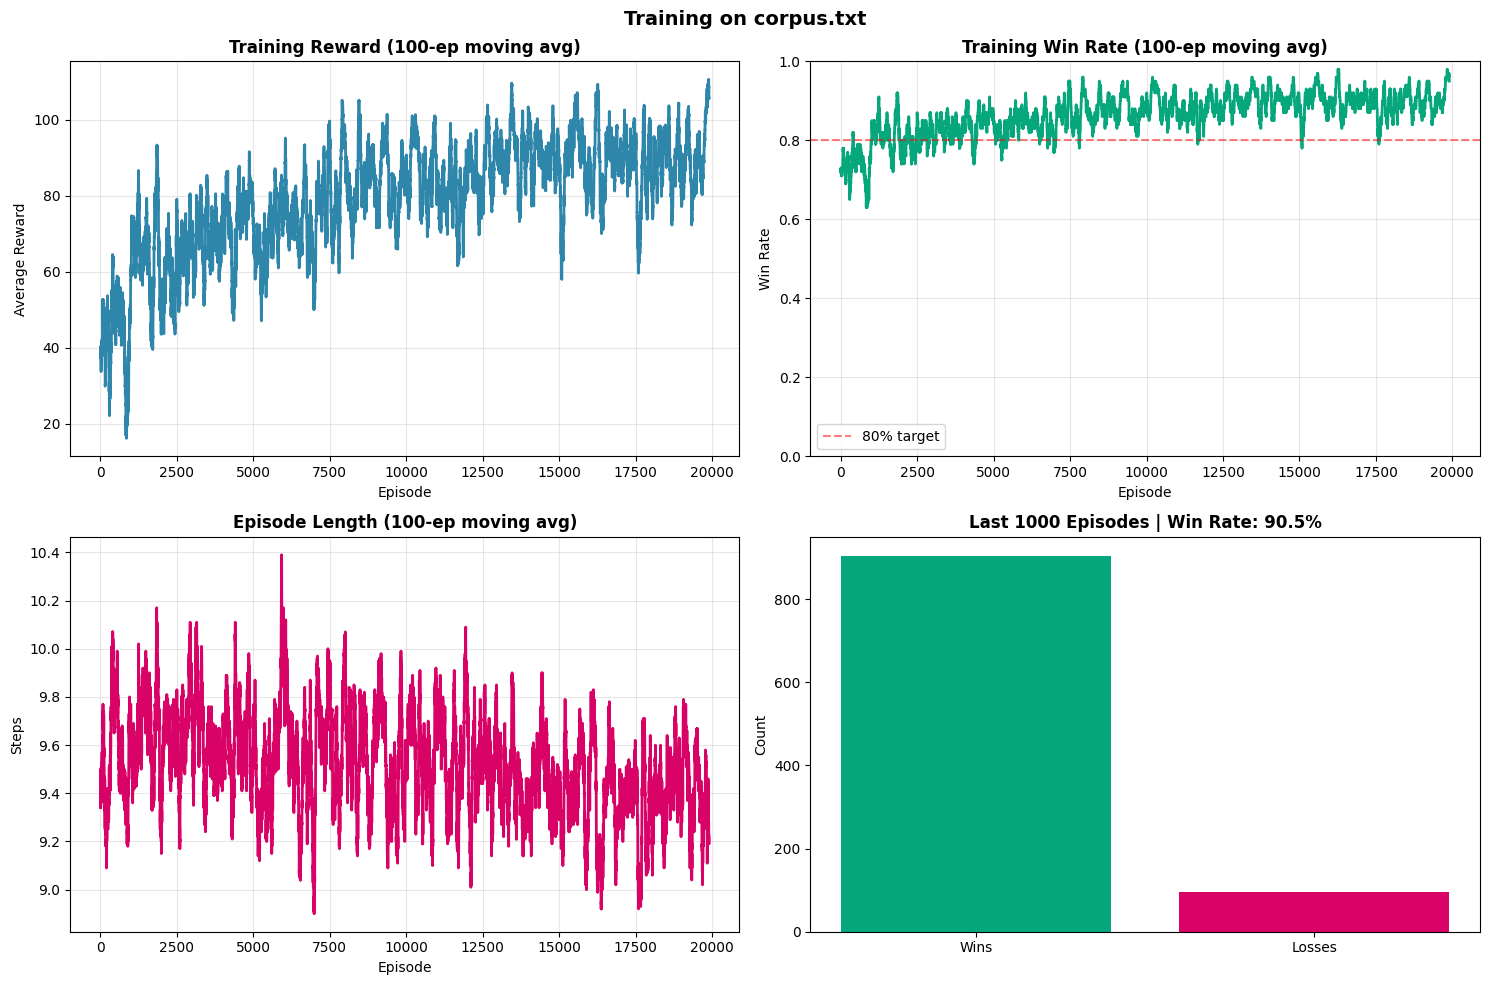

📈 Final training win rate: 90.5%


In [59]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Reward plot
window = 100
rewards_smooth = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
axes[0, 0].plot(rewards_smooth, linewidth=2, color='#2E86AB')
axes[0, 0].set_title('Training Reward (100-ep moving avg)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Average Reward')
axes[0, 0].grid(True, alpha=0.3)

# Win rate plot
wins_smooth = np.convolve(agent.wins, np.ones(window)/window, mode='valid')
axes[0, 1].plot(wins_smooth, linewidth=2, color='#06A77D')
axes[0, 1].set_title('Training Win Rate (100-ep moving avg)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Win Rate')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='80% target')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Episode lengths
length_smooth = np.convolve(agent.episode_lengths, np.ones(window)/window, mode='valid')
axes[1, 0].plot(length_smooth, linewidth=2, color='#D90368')
axes[1, 0].set_title('Episode Length (100-ep moving avg)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Steps')
axes[1, 0].grid(True, alpha=0.3)

# Win/Loss bar
recent_wins = agent.wins[-1000:]
win_rate = sum(recent_wins) / len(recent_wins)
axes[1, 1].bar(['Wins', 'Losses'],
               [sum(recent_wins), len(recent_wins) - sum(recent_wins)],
               color=['#06A77D', '#D90368'])
axes[1, 1].set_title(f'Last 1000 Episodes | Win Rate: {win_rate:.1%}',
                     fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Count')

plt.suptitle('Training on corpus.txt', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"📈 Final training win rate: {win_rate:.1%}")

In [60]:
print("\n" + "="*70)
print("EVALUATING ON TEST SET (test.txt)")
print("="*70)

# Create TEST environment using test.txt
test_env = HangmanEnvironment(test_words, max_wrong=6)
print(f"\n✓ Test environment created with {len(test_words)} words from test.txt")

# Evaluate
print(f"\n🧪 Evaluating agent on {len(test_words)} test games...")
results = agent.evaluate(test_env, num_games=len(test_words))

# Display results
print("\n" + "="*70)
print("FINAL TEST RESULTS")
print("="*70)
print(f"\n📊 Performance Metrics:")
print(f"   Success Rate: {results['success_rate']:.2%} ({results['wins']}/{results['total_games']})")
print(f"   Total Wrong Guesses: {results['total_wrong']}")
print(f"   Total Repeated Guesses: {results['total_repeated']}")
print(f"   Avg Wrong/Game: {results['total_wrong']/results['total_games']:.2f}")
print(f"   Avg Repeated/Game: {results['total_repeated']/results['total_games']:.2f}")
print("\n" + "-"*70)
print(f"🏆 FINAL SCORE: {results['final_score']:.2f}")
print("="*70)

print("\n💡 Score Formula:")
print(f"   = (Success Rate × Games × 2) - (Wrong × 5) - (Repeated × 2)")
print(f"   = ({results['success_rate']:.4f} × {results['total_games']} × 2) - ({results['total_wrong']} × 5) - ({results['total_repeated']} × 2)")
print(f"   = {results['final_score']:.2f}")


EVALUATING ON TEST SET (test.txt)

✓ Test environment created with 2000 words from test.txt

🧪 Evaluating agent on 2000 test games...
   Evaluated 500/2000 games...
   Evaluated 1000/2000 games...
   Evaluated 1500/2000 games...
   Evaluated 2000/2000 games...

FINAL TEST RESULTS

📊 Performance Metrics:
   Success Rate: 30.15% (603/2000)
   Total Wrong Guesses: 10533
   Total Repeated Guesses: 0
   Avg Wrong/Game: 5.27
   Avg Repeated/Game: 0.00

----------------------------------------------------------------------
🏆 FINAL SCORE: -51459.00

💡 Score Formula:
   = (Success Rate × Games × 2) - (Wrong × 5) - (Repeated × 2)
   = (0.3015 × 2000 × 2) - (10533 × 5) - (0 × 2)
   = -51459.00


Visualizing Test Set Evaluation Results

This section plots the agent's performance on the test dataset to assess how well it generalizes after training.

What’s Being Plotted:
1.Win/Loss Pie Chart:
   -Shows the proportion of wins and losses in the test games.
   -Helps understand the overall success rate of the trained agent.

2.Guesses Breakdown Bar Chart:
   -Displays the total number of wrong guesses and repeated guesses.
   -Indicates how efficiently the agent guesses letters.

3.Average Metrics Bar Chart:
   -Shows the average number of wrong and repeated guesses per game.
   -Reflects the agent’s accuracy and consistency across all test games.

Purpose:
To evaluate the final performance of the trained agent and measure how well it plays the Hangman game without further learning.


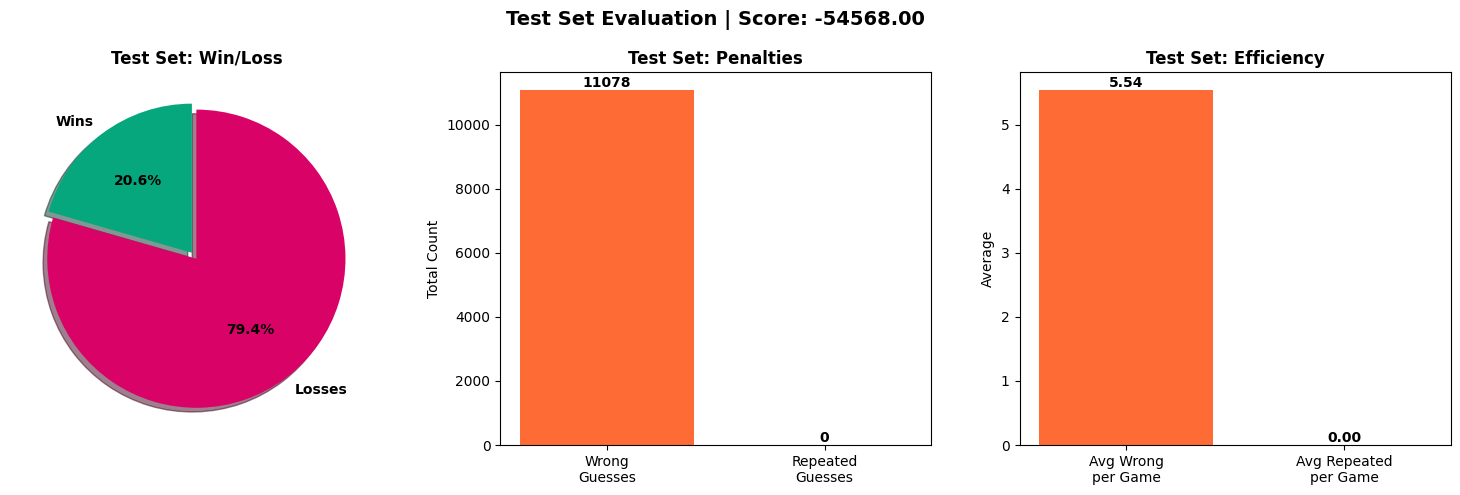

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Win/Loss pie
ax1 = axes[0]
sizes = [results['wins'], results['total_games'] - results['wins']]
colors = ['#06A77D', '#D90368']
explode = (0.05, 0)
ax1.pie(sizes, explode=explode, labels=['Wins', 'Losses'], colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontweight': 'bold'})
ax1.set_title('Test Set: Win/Loss', fontweight='bold', fontsize=12)

# Guesses breakdown
ax2 = axes[1]
categories = ['Wrong\nGuesses', 'Repeated\nGuesses']
values = [results['total_wrong'], results['total_repeated']]
bars = ax2.bar(categories, values, color=['#FF6B35', '#D90368'])
ax2.set_title('Test Set: Penalties', fontweight='bold', fontsize=12)
ax2.set_ylabel('Total Count')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Average metrics
ax3 = axes[2]
metrics = ['Avg Wrong\nper Game', 'Avg Repeated\nper Game']
avg_values = [results['total_wrong']/results['total_games'],
              results['total_repeated']/results['total_games']]
bars = ax3.bar(metrics, avg_values, color=['#FF6B35', '#D90368'])
ax3.set_title('Test Set: Efficiency', fontweight='bold', fontsize=12)
ax3.set_ylabel('Average')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle(f'Test Set Evaluation | Score: {results["final_score"]:.2f}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()